# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
import os
os.chdir('/m/nbe/project/rtmeg/problearn/mneflow/')

import tensorflow as tf
import numpy as np
import mne
from mne.datasets import multimodal
import mneflow
mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

<Info | 26 non-empty fields
    acq_pars : str | 12870 items
    acq_stim : str | 45 items
    bads : list | 0 items
    ch_names : list | MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, ...
    chs : list | 204 items (GRAD: 204)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 27 items
    dev_head_t : Transform | 3 items
    dig : list | 21 items
    events : list | 1 items
    experimenter : str | 8 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 172.17630004882812 Hz
    meas_date : tuple | 2011-04-26 11:33:18 GMT
    meas_id : dict | 4 items
    nchan : int | 204
    proc_history : list | 0 items
    proj_id : ndarray | 1 items
    proj_name : str | 4 items
    projs : list | grad_ssp_upright.fif : PCA-v1: on, ...
    sfreq : float | 600.614990234375 Hz
    subject_info : dict | 9 items
    ctf_head_t : NoneType
    dev_ctf

### Convert epochs to TFRecord format

In [2]:
#Specify import options
import_opt = dict(savepath='/m/nbe/project/rtmeg/problearn/mneflow/tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  val_size=0.15,  # validation set size set to 15% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

processing epochs
input shapes: X- (940, 204, 361) targets- (940,)
training set: X- (799, 204, 302)  y- (799, 8)
validation set: X- (141, 204, 302)  y- (141, 8)
train preprocessed: (799, 1, 302, 204) (799, 8)
Prepocessed sample shape: (1, 302, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [3]:
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)

ds batch size: 100
ds batch size: 142
setting batch size to default (100)
ds batch size: 100


# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.keras_models.Model for more details.
In this example will we use LF-CNN network


In [4]:
# specify model parameters
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-4)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

Built: demix input: (None, 1, 302, 204)
demix : output : (None, 1, 302, 32)
Built: lf_conv input: (None, 1, 302, 32)
lf_conv : output : (None, 1, 302, 32)
max_pool : output : (None, 1, 61, 32)
fc :::
Built: fc input: (None, 1, 61, 32)
fc : output : (None, 8)
Input shape: (1, 302, 204)
y_pred: (None, 8)
Initialization complete!


In [5]:
#train the model for 10 epochs
model.train(n_epochs=10, 
            eval_step=100, 
            early_stopping=3)

Train for 100 steps, validate for 1 steps
Epoch 1/10
demix : output : (None, 1, 302, 32)
lf_conv : output : (None, 1, 302, 32)
max_pool : output : (None, 1, 61, 32)
fc : output : (None, 8)
demix : output : (None, 1, 302, 32)
lf_conv : output : (None, 1, 302, 32)
max_pool : output : (None, 1, 61, 32)
fc : output : (None, 8)
 99/100 [============================>.] - ETA: 0s - loss: 1.2132 - accuracy: 0.5665demix : output : (None, 1, 302, 32)
lf_conv : output : (None, 1, 302, 32)
max_pool : output : (None, 1, 61, 32)
fc : output : (None, 8)
100/100 [==============================] - 18s 181ms/step - loss: 1.2045 - accuracy: 0.5700 - val_loss: 0.5005 - val_accuracy: 0.8169
Epoch 2/10
100/100 [==============================] - 18s 176ms/step - loss: 0.1720 - accuracy: 0.9495 - val_loss: 0.3427 - val_accuracy: 0.9155
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0584 - accuracy: 0.9846 - val_loss: 0.4175 - val_accuracy: 0.9014
Epoch 4/10
100/100 [===========

# 4. Explore the trained model parameters
LFCNN allows exploring parameters learned from the data in terms of toporaphies and the spectral properties of the latent sources contributing to each class

ds batch size: 142
demix : output : (None, 1, 302, 32)
lf_conv : output : (None, 1, 302, 32)
max_pool : output : (None, 1, 61, 32)
fc : output : (None, 8)
demix : output : (71, 1, 302, 32)
lf_conv : output : (71, 1, 302, 32)
max_pool : output : (71, 1, 61, 32)


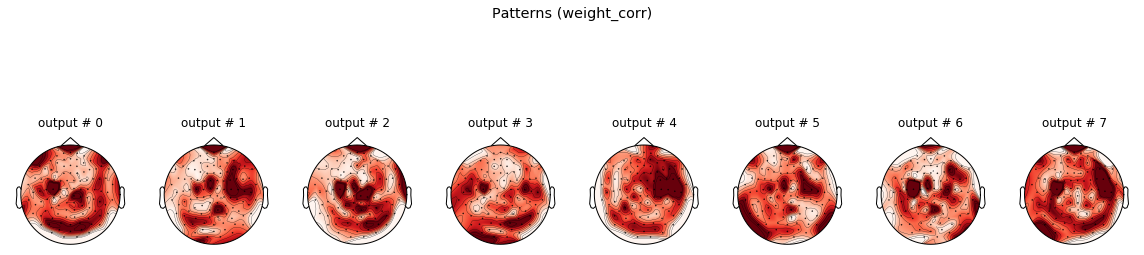

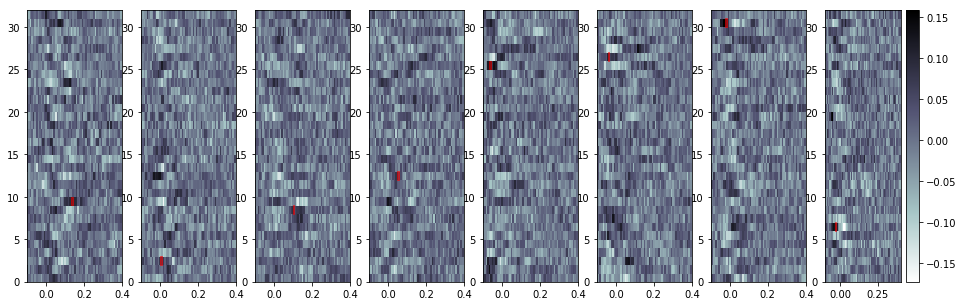

In [6]:
model.compute_patterns(meta['val_paths'])
model.plot_patterns('Vectorview-grad', sorting='weight_corr')

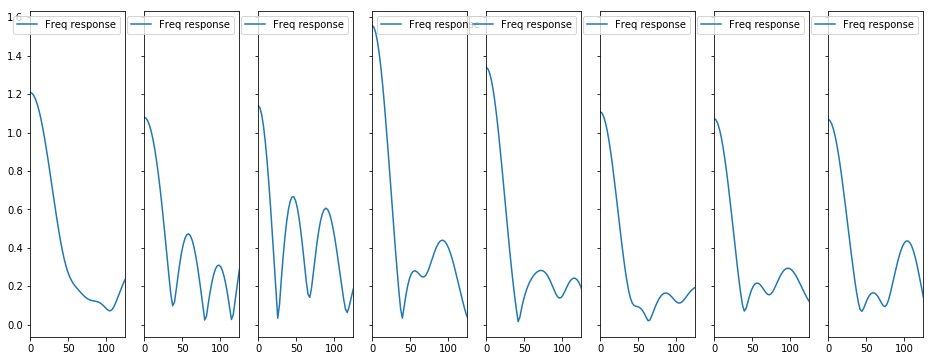

In [7]:
f2 = model.plot_spectra(sorting='weight_corr')